<a href="https://colab.research.google.com/github/projktapp/InstrumentosOpticos/blob/main/Entregable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv


def fraunhofer_transform(image_matrix,
                         wavelength=632.8e-9,  # e.g., 632.8 nm (He-Ne laser)
                         focal_length=0.2,      # 0.2 m
                         pixel_size=6.5e-6,     # pixel pitch, 6.5 microns
                        ):

    img = np.asarray(image_matrix, dtype=np.complex128)

    # 3. Get image dimensions
    ny, nx = img.shape  # ny: number of rows (height), nx: number of columns (width)
    print(nx)

    # 4. Compute the 2D FFT of the image
    fft_field = np.fft.fft2(img)

    fft_field = np.fft.fftshift(fft_field)  # Shift zero frequency to center

    # 5. Calculate the intensity (magnitude squared of FFT)
    intensity = np.abs(fft_field)**2

    # 6. Calculate spatial frequency increments
    df_x = 1.0 / (nx * pixel_size)  # cycles/m
    df_y = 1.0 / (ny * pixel_size)  # cycles/m

    # 7. Generate frequency coordinates (shifted)
    fx = (np.arange(nx) - nx/2) * df_x  # cycles/m
    fy = (np.arange(ny) - ny/2) * df_y  # cycles/m

    # 8. Map frequency coordinates to physical coordinates in diffraction pattern
    U = wavelength * focal_length * fx  # meters
    V = wavelength * focal_length * fy  # meters

    output_pixel_size = (U[-1] - U[0])/nx

    return U, V, output_pixel_size, fft_field, intensity

def realCoord(U, V, intensity):

    # 9. Apply logarithmic scaling for better visualization
    display_pattern = np.log(intensity + 1)  # Log scale; +1 to prevent log(0)

    # 10. Plot the Fraunhofer diffraction pattern
    fig, ax = plt.subplots(figsize=(8,6))

    # Define the extent of the plot in meters [xmin, xmax, ymin, ymax]
    #extent = [U[0], U[-1], V[0], V[-1]]
    extent = [-3.5328e-3, 3.5328e-3, -3.5328e-3, 3.5328e-3]


    # Display the diffraction pattern
    im = ax.imshow(display_pattern,
                   extent=extent,
                   cmap='viridis',       # Choose a perceptually uniform colormap
                   origin='lower',       # Place the [0,0] point at the lower-left corner
                   aspect='auto')         # Allow the aspect ratio to adjust automatically

    # Label the axes
    ax.set_xlabel("u (meters)")
    ax.set_ylabel("v (meters)")
    ax.set_title("Fraunhofer Diffraction Pattern")

    # Add a colorbar with label
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Intensity (arbitrary units)', rotation=270, labelpad=15)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

def create_pupil(u, v, spot_centers, removal_radius=0.0003):
    U2D, V2D = np.meshgrid(u, v)
    pupil = np.ones_like(U2D)
    for center_u, center_v in spot_centers:
        mask = ((U2D - center_u)**2 + (V2D - center_v)**2) <= removal_radius**2
        pupil[mask] = 0
    return pupil

def create_circular_aperture(u, v, radius, center=(0, 0)):

    # Create 2D coordinate grids
    U2D, V2D = np.meshgrid(u, v)

    # Calculate squared distance from the center
    r_sq = radius ** 2
    dist_sq = (U2D - center[0])**2 + (V2D - center[1])**2

    # Create the circular aperture (1 inside radius, 0 outside)
    aperture = (dist_sq <= r_sq).astype(float)

    return aperture

def flip_matrix_vertically(matrix):
    """
    Given a 2D matrix (list of lists), return a new matrix
    with row order reversed (i.e., top <-> bottom).
    """
    return matrix[::-1]

def create_hilbert_mask_smooth(u, v, dc_radius=0.0, taper_width=0.0):

    # Create 2D coordinate grids for kx = U2D, ky = V2D
    U2D, V2D = np.meshgrid(u, v, indexing='xy')

    # Initialize the mask as complex zeros
    hilbert_mask = np.zeros_like(U2D, dtype=complex)

    # Case 1: If no taper, just do the standard piecewise Hilbert
    if taper_width <= 0:
        pos_x = (U2D > 0)
        neg_x = (U2D < 0)
        hilbert_mask[pos_x] =  1j
        hilbert_mask[neg_x] = -1j

    else:
        # Define regions: Far left, Far right, and Middle (where we taper)
        pos_x = (U2D >  +taper_width)
        neg_x = (U2D <  -taper_width)
        mid_x = np.logical_not(pos_x | neg_x)  # -taper_width <= kx <= +taper_width

        # Far right: +i
        hilbert_mask[pos_x] =  1j

        # Far left: -i
        hilbert_mask[neg_x] = -1j

        # Smooth transition in the middle region
        # We'll do a simple linear interpolation from -i at kx=-taper_width
        # to +i at kx=+taper_width.
        kx_mid = U2D[mid_x]

        # Map kx in [-taper_width, +taper_width] → alpha in [0,1]
        # alpha=0 => -i,  alpha=1 => +i
        alpha = (kx_mid + taper_width) / (2.0 * taper_width)  # in [0,1]

        # Now linearly go from -1 to +1 in imaginary amplitude:
        # value = i * (2*alpha - 1)
        # => -i at alpha=0, +i at alpha=1
        value_mid = 1j * (2.0*alpha - 1.0)

        hilbert_mask[mid_x] = value_mid

    # Optional: Block (set to 0) a circular DC region of radius dc_radius
    if dc_radius > 0:
        dist_sq = U2D**2 + V2D**2
        block_region = (dist_sq <= dc_radius**2)
        hilbert_mask[block_region] = 0+0j

    return hilbert_mask











768
3.5328
0.0003245768229166667


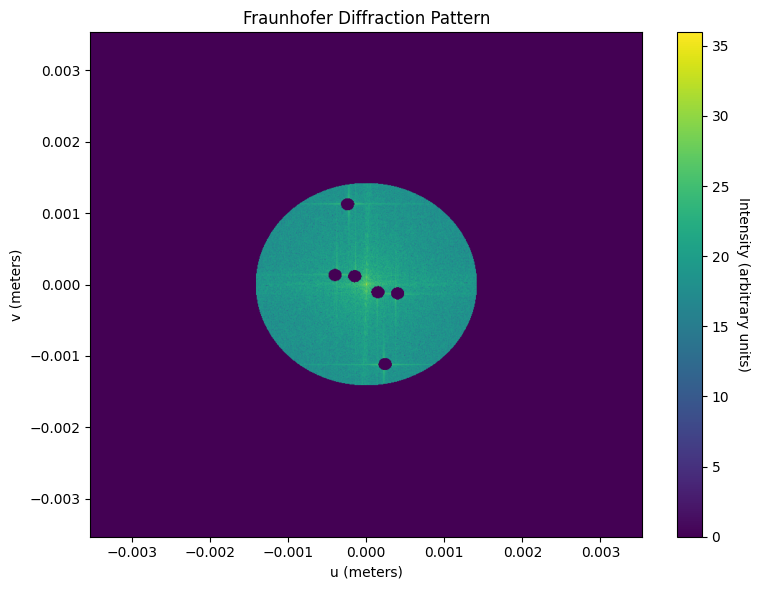

768


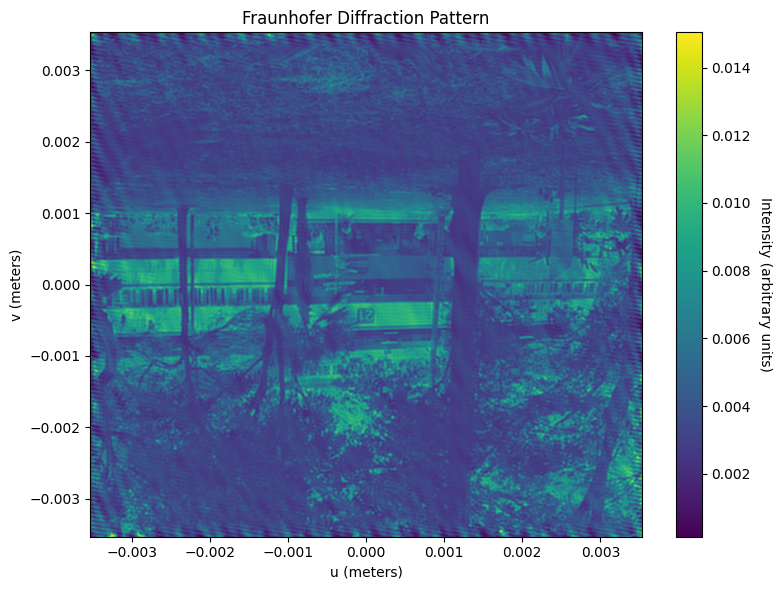

In [ ]:
    import cv2
    from PIL import Image

    # Define the path to your image file
    image_path = 'Ruido_E01.png'  # Replace with your image file path
    lamb = 650e-9

    # Load the image using OpenCV in grayscale
    img_cv = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_cv = img_cv.astype(np.float64)  # Convert to float for FFT

    U1, V1, pixelsizeOut, fftfield1, intensity1 = fraunhofer_transform(img_cv,
                                                     wavelength=lamb,    # 632.8 nm
                                                     focal_length=0.5,       # 0.2 meters
                                                     pixel_size= 0.001/768)       # 6.5 microns


    f2 = (3.45e-6 * 2048)*0.5/0.001
    print(f2)
    multiplier = f2*lamb*20
    print(pixelsizeOut)
    spot_centers = [
    (-0.01413,  0.00452),
    (-0.00523,  0.00396),
    (-0.00848,  0.03952),
    ( 0.01413, -0.00452),
    ( 0.00523, -0.00396),
    ( 0.00848, -0.03952),
    ]


    pupil = create_pupil(U1, V1, spot_centers, 0.003)
    opening = create_circular_aperture(U1, V1, 0.05)

    fftfield1 = fftfield1*pupil*opening

    # Visualize the diffraction pattern
    diffraction_pattern1 = intensity1*opening*pupil
    realCoord(U1, V1, diffraction_pattern1)

    U2, V2, pixelsizeOut2, fftfield2, intensity2 = fraunhofer_transform(fftfield1,
                                                     wavelength=lamb,    # 632.8 nm
                                                     focal_length=f2,       # 0.2 meters
                                                     pixel_size= pixelsizeOut)      # 6.5 microns

    fftfield2 = np.fft.fftshift(fftfield2)

    intensity2 = (np.abs(fftfield2)**2)/1000000000000000000

    intensity2 = flip_matrix_vertically(intensity2)

    # Visualize the diffraction pattern
    realCoord(U2, V2, intensity2)



<ipython-input-4-2e69c8fb2a33>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = df.applymap(parse_complex).to_numpy()


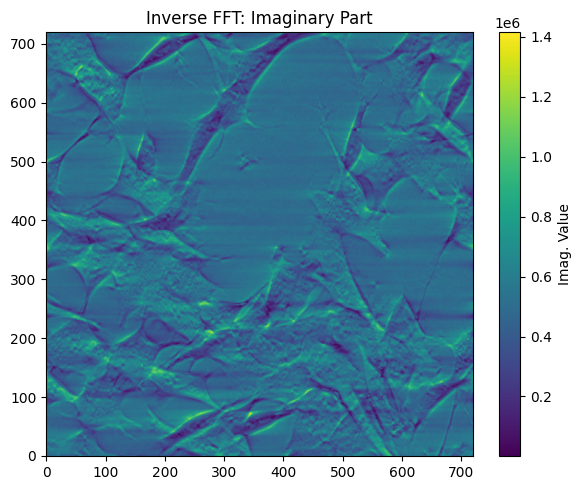

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_complex_csv(csv_path):
    """
    Reads a CSV file where each cell contains a complex number in the format 'a+bi' or 'a-bi'.
    """
    df = pd.read_csv(csv_path, header=None)

    def parse_complex(cell):
        try:
            cell = cell.strip()
            cell = cell.replace('i', 'j')
            return complex(cell)
        except:
            return 0+0j

    data = df.applymap(parse_complex).to_numpy()
    return data

def create_half_plane_phase_mask(U, V, orientation='vertical'):
    """
    Create a 2D half-plane phase mask that applies +pi/2 to one half and -pi/2 to the other.
    """
    H = np.ones_like(U, dtype=complex)

    if orientation == 'vertical':
        H[U >= 0] *= 1j
        H[U < 0]  *= -1j
    elif orientation == 'horizontal':
        H[V >= 0] *= 1j
        H[V < 0]  *= -1j
    else:
        raise ValueError("Orientation must be 'vertical' or 'horizontal'.")
    return H

def process_csv_with_half_plane_mask(csv_path,
                                     wavelength=632.8e-9,
                                     focal_length=0.2,
                                     pixel_size=6.5e-6,
                                     orientation='vertical',
                                     do_log_scale=True):

    # 1. Load complex data
    data = read_complex_csv(csv_path)
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array.")

    ny, nx = data.shape

    # 2. FFT and shift
    fft_field = np.fft.fftshift(np.fft.fft2(data))

    # 3. Build frequency grid
    df_x = 1.0 / (nx * pixel_size)
    df_y = 1.0 / (ny * pixel_size)
    fx = (np.arange(nx) - nx/2) * df_x
    fy = (np.arange(ny) - ny/2) * df_y

    # Convert spatial frequencies to physical coords at the focal plane
    U = wavelength * focal_length * fx
    V = wavelength * focal_length * fy
    U_grid, V_grid = np.meshgrid(U, V)



    # 4. Create the half-plane phase mask
    phase_mask = create_half_plane_phase_mask(U_grid, V_grid, orientation=orientation)

    # 5. Multiply the FFT by the mask
    fft_after_mask = fft_field * phase_mask

    # 6. Inverse FFT
    inverse_field = np.fft.fft2(np.fft.ifftshift(fft_after_mask))

    # 7. Take the imaginary part
    imaginary_part = np.abs(inverse_field)

    imaginary_part = flip_matrix_vertically(imaginary_part)

    # 8. Plot ONLY the imaginary part
    plt.figure(figsize=(6, 5))
    plt.imshow(imaginary_part, cmap='viridis', origin='lower', aspect='auto')
    plt.title("Inverse FFT: Imaginary Part")
    plt.colorbar(label="Imag. Value")
    plt.tight_layout()
    plt.show()

    # Return intermediate data if needed
    return fft_field, phase_mask, fft_after_mask, inverse_field, imaginary_part

# Example usage
if __name__ == "__main__":
    fft_field, phase_mask, fft_after_mask, inverse_field, imag_part = process_csv_with_half_plane_mask(
        "MuestraBio_E01.csv",
        wavelength=632.8e-9,
        focal_length=0.01,
        pixel_size=6.5e-6,
        orientation='vertical',
        do_log_scale=True
    )


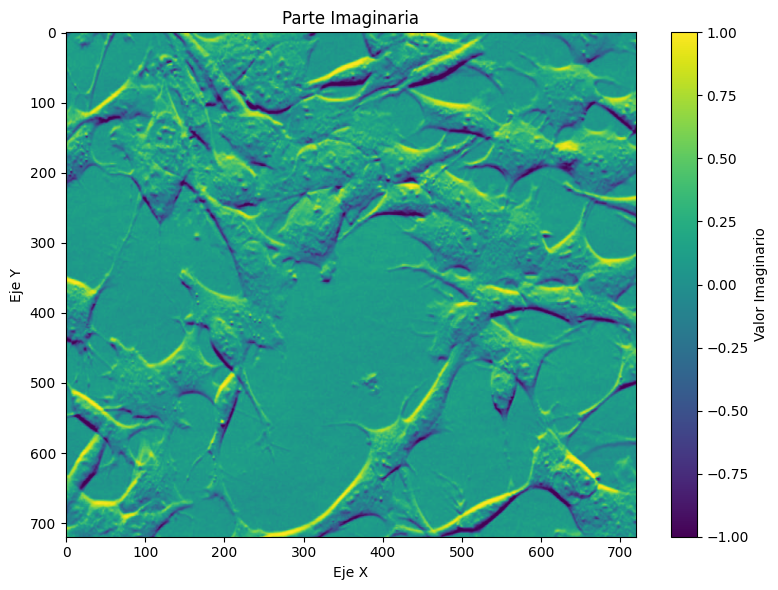

In [13]:
import csv
import numpy as np
import matplotlib.pyplot as plt

def parse_complex(cell):
    """
    Parsea una cadena que representa un número complejo.
    La entrada se espera en la forma 'a+bi' o 'a-bi', por ejemplo, '0.994521895368273-0.104528463267654i'.
    Esta función reemplaza 'i' por 'j' para que la función complex() de Python pueda parsearlo.
    """
    cell = cell.strip()
    if not cell:
        raise ValueError("Celda vacía")

    # Reemplazar la unidad imaginaria 'i' por 'j'
    cell = cell.replace('i', 'j')
    try:
        return complex(cell)
    except ValueError as e:
        raise ValueError(f"No se puede parsear el número complejo de: {cell}") from e

# Leer el archivo CSV y parsearlo en una matriz de números complejos
matrix = []
with open('MuestraBio_E01.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        complex_row = []
        for cell in row:
            if cell.strip():
                try:
                    c = parse_complex(cell)
                    complex_row.append(c)
                except ValueError as e:
                    print(f"Advertencia: Saltando la celda '{cell}': {e}")
        if complex_row:
            matrix.append(complex_row)

# Verificar si se obtuvieron datos
if not matrix:
    raise ValueError("No se encontraron datos válidos en el archivo.")

# Convertir la lista de listas en un arreglo de NumPy
matrix = np.array(matrix)

# Calcular solo la parte imaginaria
imag_matrix = np.imag(matrix)

# Crear un gráfico 2D usando Matplotlib
plt.figure(figsize=(8, 6))
im1 = plt.imshow(imag_matrix, cmap='viridis', aspect='auto')
plt.title("Parte Imaginaria")
plt.colorbar(im1, label='Valor Imaginario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.tight_layout()
plt.show()
